# Computational Graphs - Function Optimization
*Christoph Heindl 2017, https://github.com/cheind/py-cgraph/*

This is part three in series about computational graphs and their applications. In the previous parts the fundamental concepts were covered. We also introduced a library called CGraph to perform symbolic computation in Python.

This part is about putting CGraph into practice. It deals with function optimization in which derivatives are required to determine stationary points.

## Function optimization

Now with all the puzzle-pieces in place and a working symbolic computation engine (at least for computing derivatives) at hand, we will apply it to function optimization. In particular, we will be dealing with least squares problems in which the residuals are linear, though nothing prevents you from applying it to other non-linear problems.

Our secenario is as follows: Given a set of noisy two-dimensional points fit a straight line. Everyone whose done ordinary linear least square regression knows that there is a 'closed-form' solution to the problem that involves nothing but a couple of matrix multiplications and an inversion. However, here we shall use the best-fit solution only as reference and concentrate more on gradient descent methods that are also the driving horses for training neural networks.

For the time being, we'll be using [cgraph.py](../cgraph.py) directly, as it contains operations that we haven't implemented yet in the previois part. The complete example can be found exercised here is also available as a separate [example_optimize.py](../example_optimize.py) file.

In [13]:
import sys
sys.path.append('..')
import cgraph as cg

First, we define a function that generates a set of noisy points along an ideal line parametrized by $y = w_0*x+w_1$

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def generate_points(n, k, d):
    x = np.linspace(0, 10, n)
    y = x * k + d + np.random.normal(scale=0.15, size=n)
    return np.vstack((x,y))

# Parameters of ideal line
k = 0.8
d = 2.0

samples = generate_points(20, k, d)

Let's plot the samples

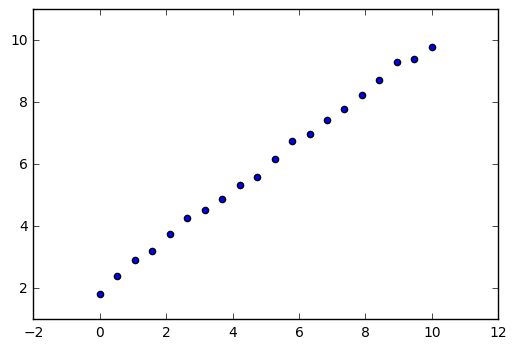

In [15]:
plt.scatter(samples[0,:], samples[1,:])
plt.show()

Next, we define the objective function to be minimized
$$f(w_0,w_1;x_0..x_n, y_0..y_n) = \sum_i^n{(w_0*x_i + w_1 - y_i)^2}$$
with respect to the unknown parameters $w_0$ and $w_1$.

We are searching for a minimum of the sum of squared residuals between a line parametrized by $w_0$, $w_1$ and the samples given. Note that the error is measured along the y-axis (called the algebraic distance). In case you are interested see [ordinary-least-squares](https://en.wikipedia.org/wiki/Ordinary_least_squares).

It is straight forward to represent $f$ in `CGraph`

In [16]:
def sum_residuals_squared(w0, w1, xy):
    n = xy.shape[1]
    residuals = []
    for i in range(n):
        r = w0 * xy[0,i] + w1 - xy[1,i]
        residuals.append(r**2)

    return cg.sym_sum(residuals) / n

w0 = cg.Symbol('w0')
w1 = cg.Symbol('w1')

f = sum_residuals_squared(w0, w1, samples)

Note the `/n` is a normalizing constant. It is optional and does not the change the minimum. Its purpose is to make the gradient lengths independent of the number of point samples used.

The expression tree associated with `f` is given by

In [17]:
f

(sum((((w0*0.0) + w1) - 1.83254282929)**2, (((w0*0.526315789474) + w1) - 2.41392251072)**2, (((w0*1.05263157895) + w1) - 2.92884331302)**2, (((w0*1.57894736842) + w1) - 3.20649659396)**2, (((w0*2.10526315789) + w1) - 3.75860036902)**2, (((w0*2.63157894737) + w1) - 4.28076197242)**2, (((w0*3.15789473684) + w1) - 4.53185353594)**2, (((w0*3.68421052632) + w1) - 4.88161565297)**2, (((w0*4.21052631579) + w1) - 5.34124269706)**2, (((w0*4.73684210526) + w1) - 5.60637130476)**2, (((w0*5.26315789474) + w1) - 6.18994210356)**2, (((w0*5.78947368421) + w1) - 6.75212287882)**2, (((w0*6.31578947368) + w1) - 6.98051764488)**2, (((w0*6.84210526316) + w1) - 7.44441377805)**2, (((w0*7.36842105263) + w1) - 7.77579118754)**2, (((w0*7.89473684211) + w1) - 8.25562282707)**2, (((w0*8.42105263158) + w1) - 8.70950365482)**2, (((w0*8.94736842105) + w1) - 9.29952656356)**2, (((w0*9.47368421053) + w1) - 9.41445247338)**2, (((w0*10.0) + w1) - 9.78861561009)**2)/20)

What's given below is the reference implementation of an ordinary least squares regression. We will be using this as a reference.

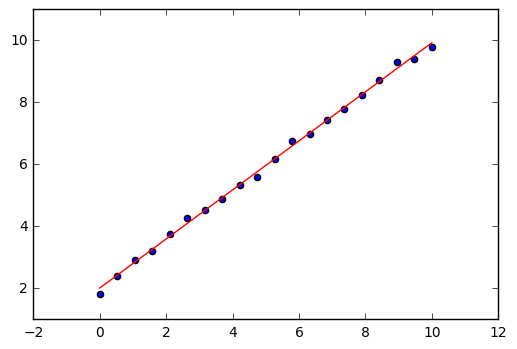

In [18]:
def least_squares_fit(xy):
    """Returns the line parameters through ordinary least squares regression."""

    A = np.ones((xy.shape[1], 2))    
    A[:,0] = xy[0,:].T
    b = xy[1,:].T

    return np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)), A.T), b)

s_fit = least_squares_fit(samples)

plt.plot([0, 10], [0*s_fit[0]+s_fit[1], 10*s_fit[0]+s_fit[1]], color='r', linestyle='-', label='Least Squares')
plt.scatter(samples[0,:], samples[1,:])
plt.show()

### Steepest descent

[Steepest descent](https://en.wikipedia.org/wiki/Method_of_steepest_descent) is an iterative optimization method that, given an initial guess, finds a better guess by taking a step in the direction of the negative gradient. Once the norm of the gradient is sufficiently close to zero, one claims to have found a stationary point (local minimum).

This method is of first-order as it requires only first order derivatives. With CGraph it can be implemented in the following way.

In [19]:
def steepest_descent(f, w0, w1, guess, verbose=True):    
    lam = 0.02

    for i in range(200):   
        df = cg.numeric_gradient(f, guess)

        guess[w0] -= lam * df[w0]
        guess[w1] -= lam * df[w1]

    if verbose:
        print('Steepest descent solution {}, {}'.format(guess[w0], guess[w1]))
        print('Error {}'.format(cg.value(f, guess)))

    return guess

In each iteration the method takes a scaled step (by `lam`) in the direction of the negative gradient. Let's see how well it converges.

Steepest descent solution 0.8060890574187736, 1.9126906037649325
Error 0.013355695155066506


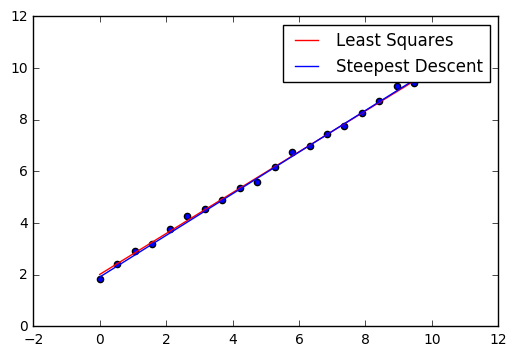

In [20]:
s_sd = steepest_descent(f, w0, w1, {w0: 0.4, w1: 1.1})

plt.plot([0, 10], [0*s_fit[0]+s_fit[1], 10*s_fit[0]+s_fit[1]], color='r', linestyle='-', label='Least Squares')
plt.plot([0, 10], [0*s_sd[w0]+s_sd[w1], 10*s_sd[w0]+s_sd[w1]], color='b', linestyle='-', label='Steepest Descent')
plt.scatter(samples[0,:], samples[1,:])
plt.legend()
plt.show()

Not quite, but also not far off from the reference. Variations of the steepest descent are the tools of the trade to train neural networks.

## Newton's method for function optimization

Next up is [Newton's method](https://en.wikipedia.org/wiki/Newton's_method_in_optimization), which frees us from a fixed step size when descenting. It comes at the cost that we need to compute second order derivatives. Although it is an iterative approach, Newton's method will take just one step for our problem setting. This is due to the fact that our object function has exactly the shape that Newton's method is approximating in each step.

In [21]:
def newton_descent(f, w0, w1, guess, verbose=True, simplify=False):
    d1 = cg.symbolic_gradient(f)        # gives df/dw0, df/dw1
    d2w0 = cg.symbolic_gradient(d1[w0]) # gives ddf/dw0dw0, ddf/dw0dw1,
    d2w1 = cg.symbolic_gradient(d1[w1]) # gives ddf/dw1dw1, ddf/dw1dw0,

    if simplify:
        d2w0 = cg.simplify_all(d2w0)
        d2w1 = cg.simplify_all(d2w1)
    
    def nhessian(guess):
        h = np.zeros((2,2)) 
        h[0,0] = cg.value(d2w0[w0], guess)
        h[0,1] = cg.value(d2w0[w1], guess)
        h[1,0] = cg.value(d2w1[w0], guess) # Hessian is symmetric, could reuse h[0,1]
        h[1,1] = cg.value(d2w1[w1], guess)
        return h

    def ngrad(guess):
        g = np.zeros((2,1))
        g[0, 0] = cg.value(d1[w0], guess)
        g[1, 0] = cg.value(d1[w1], guess)
        return g

    # Single step is enough, since our objective function is of quadric shape.
    step = np.linalg.inv(nhessian(guess)).dot(ngrad(guess))
    guess[w0] -= step[0,0]
    guess[w1] -= step[1,0]

    if verbose:
        print('Newton solution {}, {}'.format(guess[w0], guess[w1]))
        print('Error {}'.format(cg.value(f, guess)))

    return guess

Newton solution 0.7912784081755243, 2.0132459341697015
Error 0.010632956639986146


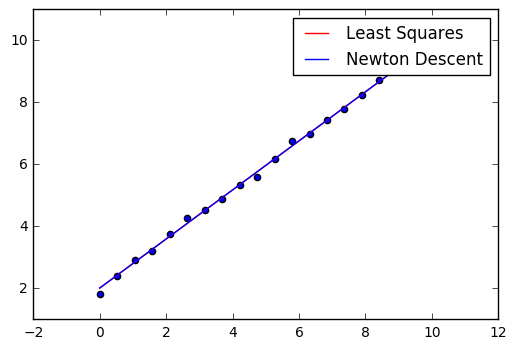

In [22]:
s_sn = newton_descent(f, w0, w1, {w0: 0.4, w1: 1.1})

plt.plot([0, 10], [0*s_fit[0]+s_fit[1], 10*s_fit[0]+s_fit[1]], color='r', linestyle='-', label='Least Squares')
plt.plot([0, 10], [0*s_sn[w0]+s_sn[w1], 10*s_sn[w0]+s_sn[w1]], color='b', linestyle='-', label='Newton Descent')
plt.scatter(samples[0,:], samples[1,:])
plt.legend()
plt.show()

Good match there. What about performance?

In [23]:
%timeit newton_descent(f, w0, w1, {w0: 0.4, w1: 1.1}, verbose=False)

10 loops, best of 3: 22.7 ms per loop


In [24]:
%timeit steepest_descent(f, w0, w1, {w0: 0.4, w1: 1.1}, verbose=False)

10 loops, best of 3: 98 ms per loop


A single step in the Newton descent is much more costly than a single iteration inside the steepest descent method. Newton's method requires us to compute second order derivatives which is computationally more expensive than going with first order derivates. Still Newton's method requires just a single step and thus converges faster than steepest descent.